In [8]:

import kagglehub
orvile_carotid_ultrasound_images_path = kagglehub.dataset_download('orvile/carotid-ultrasound-images')

print('Data source import complete.')

Data source import complete.


In [9]:
! pip install kaggle

! mkdir ~/.kaggle

! cp /content/kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [10]:
! kaggle datasets download orvile/carotid-ultrasound-images

Dataset URL: https://www.kaggle.com/datasets/orvile/carotid-ultrasound-images
License(s): Attribution 4.0 International (CC BY 4.0)
 86% 245M/284M [00:00<00:00, 820MB/s] 
100% 284M/284M [00:00<00:00, 874MB/s]


In [11]:
! unzip /content/carotid-ultrasound-images.zip

Archive:  /content/carotid-ultrasound-images.zip
  inflating: Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/Expert mask images/202201121748100022VAS_slice_1069.png  
  inflating: Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/Expert mask images/202201121748100022VAS_slice_1080.png  
  inflating: Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/Expert mask images/202201121748100022VAS_slice_1092.png  
  inflating: Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/Expert mask images/202201121748100022VAS_slice_1108.png  
  inflating: Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/Expert mask images/202201121748100022VAS_slice_1128.png  
  inflating: Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/Expert mask images/202201121748100022VAS_slice_1157.png  
  inflating: Common Carotid Artery Ultrasound

In [12]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [13]:
base_path = "/content/Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/"
image_dir = base_path + "US images/"
mask_dir = base_path + "Expert mask images/"

In [14]:
print("Sample ultrasound images:", os.listdir(image_dir)[:5])
print("Sample masks:", os.listdir(mask_dir)[:5])

Sample ultrasound images: ['202202071316520029VAS_slice_870.png', '202201121808450029VAS_slice_4687.png', '202201121815070032VAS_slice_1647.png', '202201121806070027VAS_slice_54.png', '202201121806070027VAS_slice_82.png']
Sample masks: ['202202071316520029VAS_slice_870.png', '202201121808450029VAS_slice_4687.png', '202201121815070032VAS_slice_1647.png', '202201121806070027VAS_slice_54.png', '202201121806070027VAS_slice_82.png']


In [15]:
print(f"Total images: {len(os.listdir(image_dir))}")
print(f"Total masks: {len(os.listdir(mask_dir))}")

Total images: 1100
Total masks: 1100


In [16]:
image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

In [17]:
df = pd.DataFrame({"image_path": image_files, "mask_path": mask_files})

In [18]:
df.head()

,image_path,mask_path
0,/content/Common Carotid Artery Ultrasound Imag...,/content/Common Carotid Artery Ultrasound Imag...
1,/content/Common Carotid Artery Ultrasound Imag...,/content/Common Carotid Artery Ultrasound Imag...
2,/content/Common Carotid Artery Ultrasound Imag...,/content/Common Carotid Artery Ultrasound Imag...
3,/content/Common Carotid Artery Ultrasound Imag...,/content/Common Carotid Artery Ultrasound Imag...
4,/content/Common Carotid Artery Ultrasound Imag...,/content/Common Carotid Artery Ultrasound Imag...


In [19]:
print(df.shape)
print(df.columns)
print(df.duplicated().sum())
print(df.isnull().sum())
df.info()

(1100, 2)
Index(['image_path', 'mask_path'], dtype='object')
0
image_path    0
mask_path     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  1100 non-null   object
 1   mask_path   1100 non-null   object
dtypes: object(2)
memory usage: 17.3+ KB


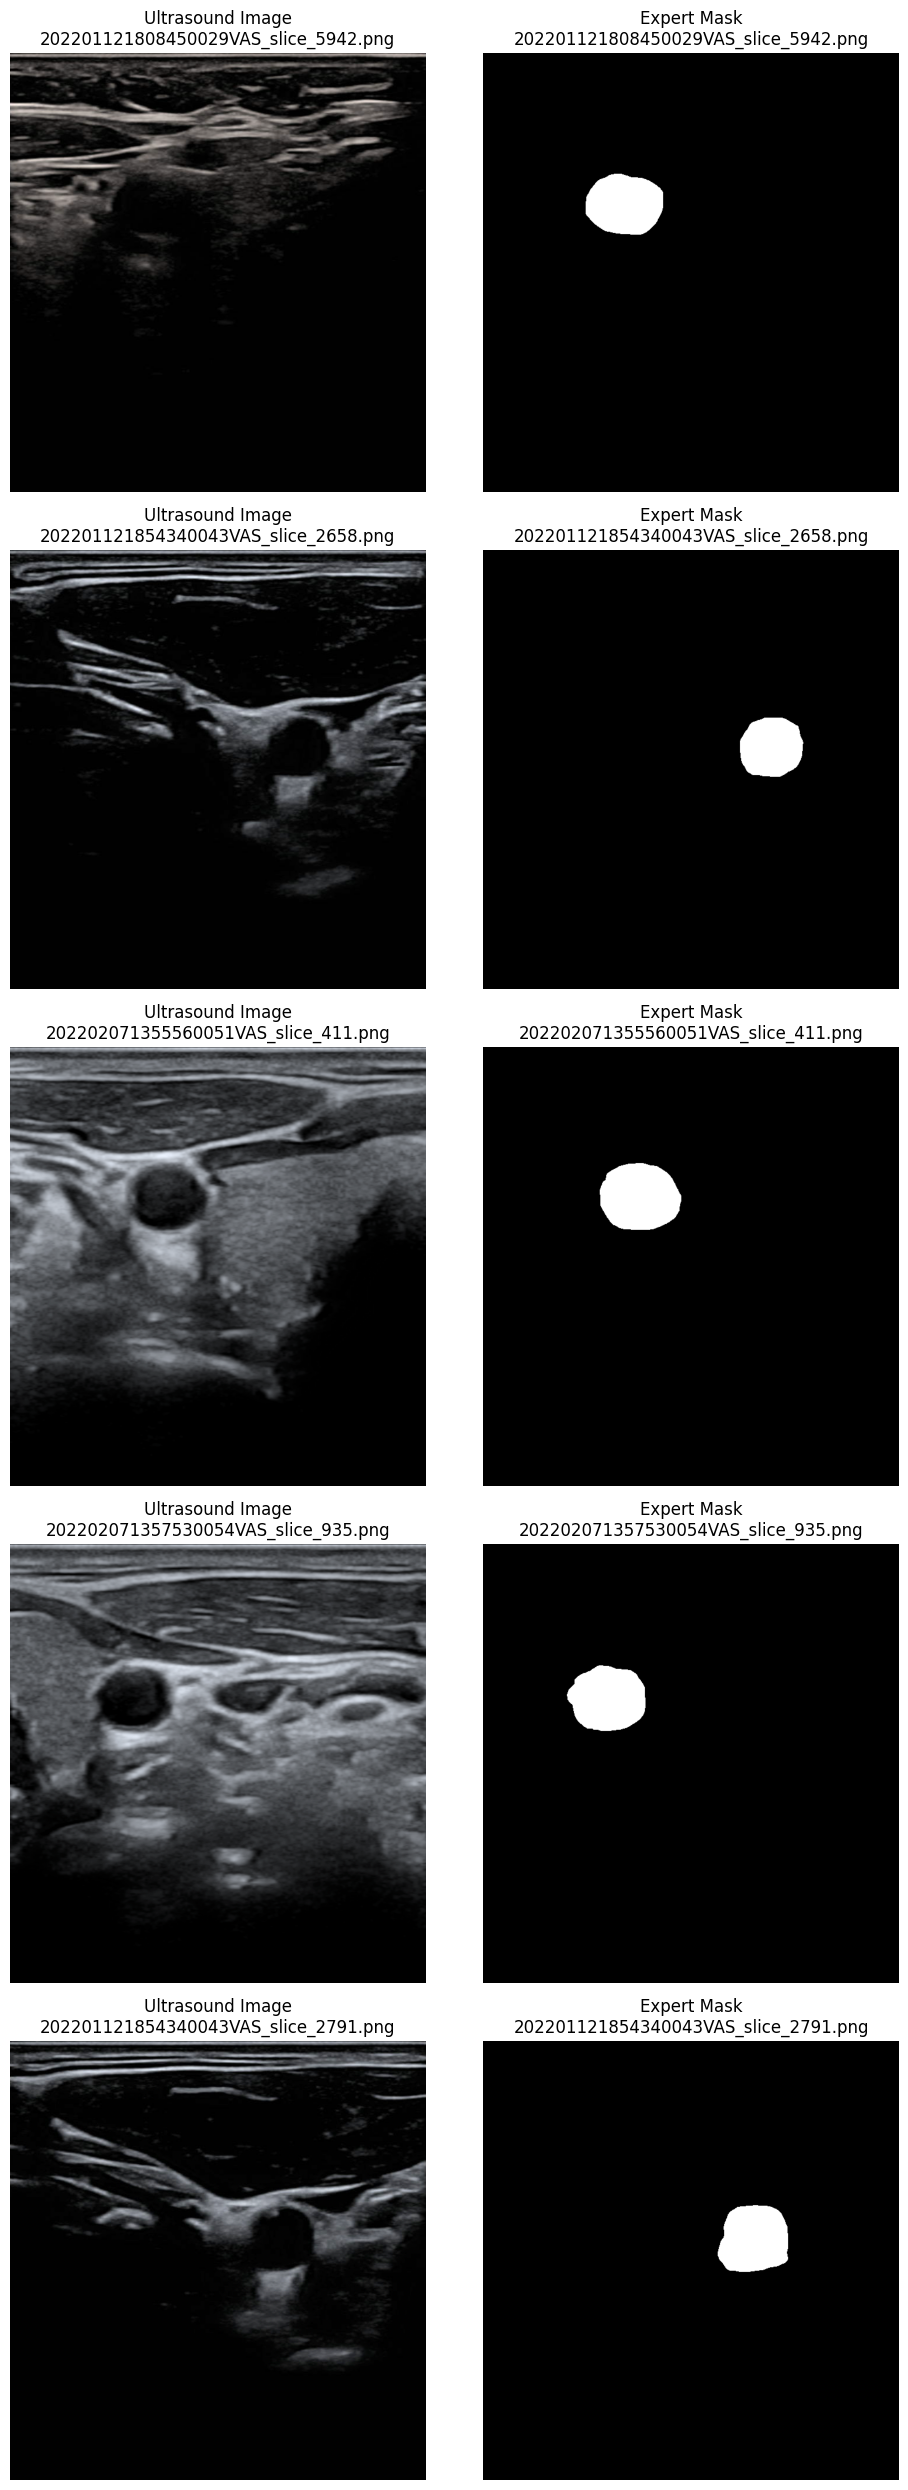

In [20]:
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

assert all(im.split('.')[0] == mk.split('.')[0] for im, mk in zip(image_files, mask_files)), "Mismatched files!"

fig, axes = plt.subplots(5, 2, figsize=(10, 25))

for idx in range(5):
    random_index = random.randint(0, len(image_files) - 1)
    img_path = os.path.join(image_dir, image_files[random_index])
    mask_path = os.path.join(mask_dir, mask_files[random_index])

    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    axes[idx, 0].imshow(img)
    axes[idx, 0].set_title(f"Ultrasound Image\n{image_files[random_index]}")
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(mask, cmap='gray')
    axes[idx, 1].set_title(f"Expert Mask\n{mask_files[random_index]}")
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

In [21]:
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]

In [22]:
missing_masks = [f for f in image_files if f not in mask_files]
if missing_masks:
    raise ValueError(f"Missing masks for {len(missing_masks)} images, including: {missing_masks[:3]}")

file_pairs = [(os.path.join(image_dir, f), os.path.join(mask_dir, f)) for f in image_files]

In [23]:
df = pd.DataFrame(file_pairs, columns=['image_path', 'mask_path'])

In [24]:
df.head()

,image_path,mask_path
0,/content/Common Carotid Artery Ultrasound Imag...,/content/Common Carotid Artery Ultrasound Imag...
1,/content/Common Carotid Artery Ultrasound Imag...,/content/Common Carotid Artery Ultrasound Imag...
2,/content/Common Carotid Artery Ultrasound Imag...,/content/Common Carotid Artery Ultrasound Imag...
3,/content/Common Carotid Artery Ultrasound Imag...,/content/Common Carotid Artery Ultrasound Imag...
4,/content/Common Carotid Artery Ultrasound Imag...,/content/Common Carotid Artery Ultrasound Imag...


In [25]:
def extract_subject_id(filename):
    """Extracts subject ID from filenames like:
    202201121748100022VAS_slice_1069.png
    202202071308300020EM VASCULAR_slice_695.png
    """
    parts = filename.split('_')
    if len(parts) < 3:
        raise ValueError(f"Unexpected filename format: {filename}")
    first_part = parts[0]
    timestamp_length = 18
    if len(first_part) < timestamp_length:
        raise ValueError(f"Unexpected first part length: {first_part}")
    identifier = first_part[timestamp_length:]
    subject_id = identifier.split()[0].strip()
    return subject_id

In [26]:
df['subject_id'] = df['image_path'].apply(lambda x: extract_subject_id(os.path.basename(x)))

print("Unique Subject IDs:", df['subject_id'].unique())

Unique Subject IDs: ['VAS' 'EM']


In [27]:

def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [28]:
def load_data(df, image_size=(256, 256)):
    images = []
    masks = []
    for image_path, mask_path in zip(df['image_path'], df['mask_path']):
        img = load_img(image_path, target_size=image_size)
        img = img_to_array(img) / 255.0
        images.append(img)

        mask = load_img(mask_path, target_size=image_size, color_mode='grayscale')
        mask = img_to_array(mask) / 255.0
        masks.append(mask)

    return np.array(images), np.array(masks)

images, masks = load_data(df)
masks = np.expand_dims(masks, axis=-1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

In [30]:
!apt-get install graphviz
!pip install graphviz pydot

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


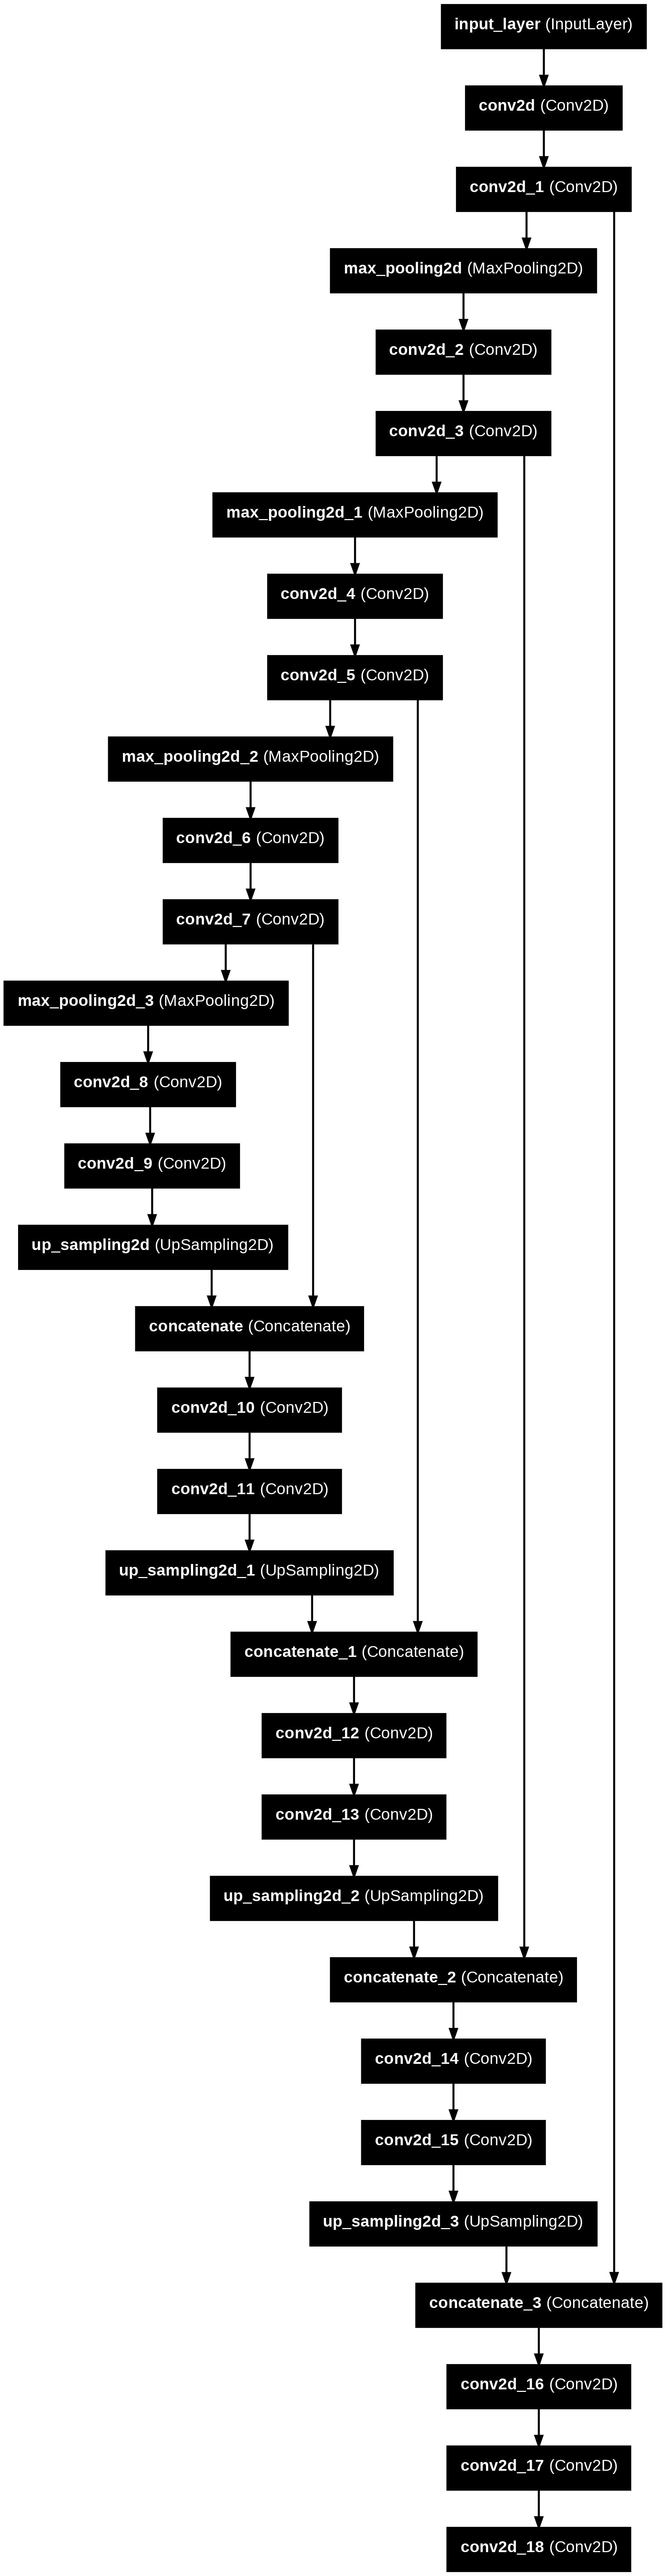

In [31]:
from tensorflow.keras.utils import plot_model

model = unet()
plot_model(model, to_file="unet_architecture.png", show_layer_names=True)

# Display image inside notebook (optional)
from IPython.display import Image
Image("unet_architecture.png")

In [40]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, verbose=1)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32, callbacks=[early_stopping, reduce_lr])

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 524ms/step - accuracy: 0.9763 - loss: 0.1366 - val_accuracy: 0.9763 - val_loss: 0.0495 - learning_rate: 0.0010
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 291ms/step - accuracy: 0.9769 - loss: 0.0413 - val_accuracy: 0.9934 - val_loss: 0.0213 - learning_rate: 0.0010
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step - accuracy: 0.9935 - loss: 0.0178 - val_accuracy: 0.9954 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step - accuracy: 0.9953 - loss: 0.0122 - val_accuracy: 0.9963 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step - accuracy: 0.9968 - loss: 0.0082 - val_accuracy: 0.9966 - val_loss: 0.0080 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9966 - loss: 0.0081
Test Loss: 0.008043724112212658, Test Accuracy: 0.9966124892234802


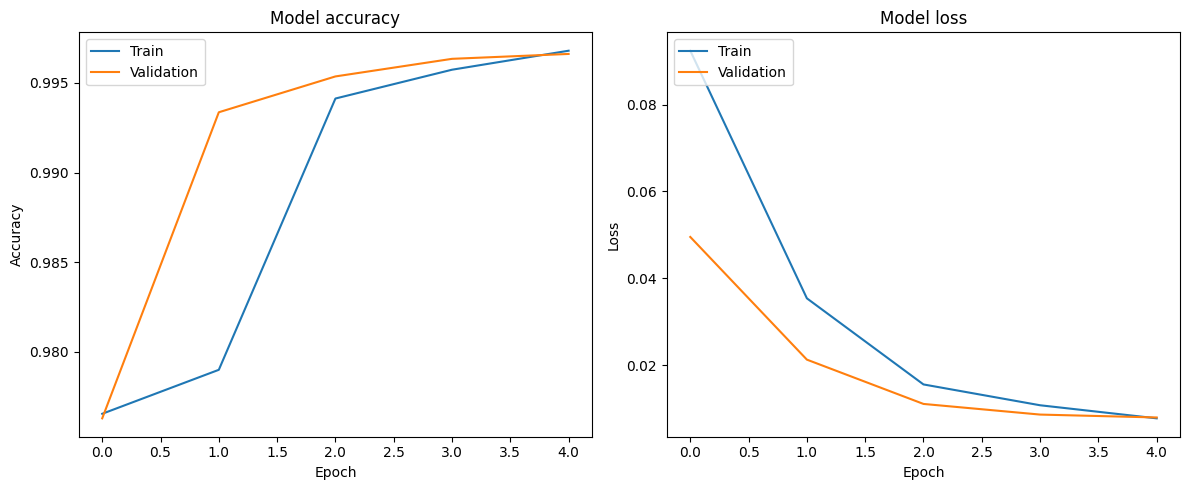

In [41]:

def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
    else:
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
    else:
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_history(history)

In [42]:
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    if union == 0:
        return 0.0
    return intersection / union

def calculate_dice(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    total = y_true.sum() + y_pred.sum()
    if total == 0:
        return 0.0
    return 2 * intersection / total

In [43]:
y_pred_binary = (model.predict(X_test) > 0.5).astype(bool)
y_test_binary = y_test.astype(bool)

iou = calculate_iou(y_test_binary.squeeze(), y_pred_binary.squeeze())
dice = calculate_dice(y_test_binary.squeeze(), y_pred_binary.squeeze())

print(f"IoU: {iou}")
print(f"Dice: {dice}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step
IoU: 0.8706585843178068
Dice: 0.9308578183285319


In [44]:

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]

 Total params: 5,887,877 (22.46 MB)

 Trainable params: 1,962,625 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,925,252 (14.97 MB)

In [45]:
model.save("model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


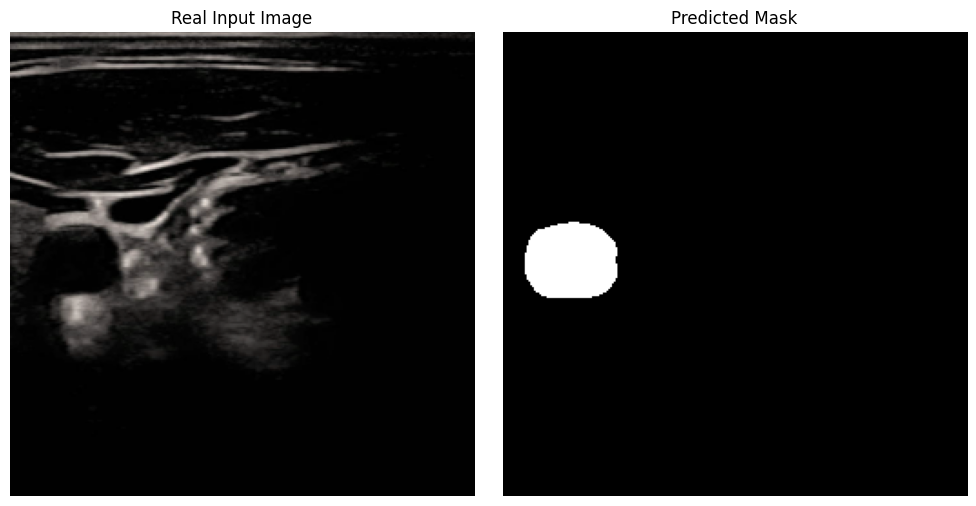

In [46]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to your real test image (change this to your image path)
real_image_path = "/content/Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/US images/202201121748100022VAS_slice_2689.png"  # ← Update as needed

# Preprocess real input image
def preprocess_single_image(img_path, target_size=(256, 256)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Test function for real image
def test_real_image(image_path):
    # Preprocess input image
    input_image = preprocess_single_image(image_path)

    # Predict using trained model
    prediction = model.predict(input_image)[0, :, :, 0]  # Get 2D prediction

    # Load original image for display
    img_show = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    img_show = cv2.resize(img_show, (256, 256))

    # Plot original image and predicted mask
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img_show)
    plt.title("Real Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(prediction > 0.5, cmap='gray')  # Show binary mask
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# 🔁 Run test
test_real_image(real_image_path)

The above is the test on the trained model